# Description

Notebook for rebuttal simulation results.

# Imports

In [3]:
%load_ext autoreload
%autoreload

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sys
import warnings

from ipywidgets import interact_manual
from linearmodels.iv import IV2SLS
from tqdm import tqdm

# user imports
sys.path.append("../")

from utils.pwr import rdd_power
from utils.sim import generate_IV_comply_indicator
from utils.clf import iv_neff, ThresholdCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reviewer KaND: known non-compliance bias

In [4]:
def simulate_per_protocol_exclusion(n_trials, **kwargs):
    """
    Simulates per-protocol exclusion procedure.
    
    Args:
        n_trials (int): number of trials to run
        kwargs: keyword arguments for gen_iv_with_comply_status
    
    Returns:
        df: a DataFrame containing:
            - trial
            - treatment effect estimate, std error, calculated power for:
                - full data simple 2SLS
                - full data 2SLS with covariates
                - s1 exclusion estimates
                - s2 exclusion estimates
            - s1, s2 number of included samples
            - s1, s2 compliance "test set" prediction accuracy
    """    
    #print("true treatment effect: {}".format(kwargs['tau']))
    # initialize data dictionary    
    data_samples = ['per_protocol']
    vals = ['tau_hat', 'std_err', 'pwr', 'n_incl', 'test_acc', 'threshold']
    df_dict = { val + "_" + data: [] for val in vals for data in data_samples}
    df_dict['trial'] = []
    
    simple_formula = 'Y ~ 1 + [T ~ Z]'
    
    for trial in range(n_trials):
        fuzzy_df = generate_IV_comply_indicator(seed=trial, **kwargs)
        feat_cols = fuzzy_df.columns[fuzzy_df.columns.str.startswith("feat")].tolist()
        extended_formula = 'Y ~ 1 + {} + [T ~ Z]'.format(' + '.join(feat_cols))

        sel_df = fuzzy_df[fuzzy_df['T'] == fuzzy_df['Z']]
        
        # simple model with per-protocl exclusion data
        populate_iv_results(df_dict, simple_formula, sel_df, kwargs['tau'], 'per_protocol')
        
        # split sample, TODO think about whether we need to stratified split on T
        np.random.seed(trial)
        
        df_dict['trial'].append(trial)
        #print("trial {}".format(trial))

    return pd.DataFrame.from_dict(df_dict)

In [9]:
def populate_iv_results(df_dict, formula, data_df, tau, data_sample, acc=np.nan, threshold=np.nan):
    """
    Runs the 2SLS estimator and populates result_dict.
    
    Args:
        df_dict (dict)
        formulat (str): the patsy regression formula to use
        data_df (pd.DataFrame): the dataframe to run over
        tau (float): target treatment effect for power calculations
        data_sample (str): the name of the data sample
        acc (float): the test accuracy of the prediction, if applicable
        threshold (float): the complier threshold cutoff, if applicable
    
    Returns:
        None, but mutates result_dict
    """
    print("data_df shape:{}".format(data_df.shape[0]))
    iv_model = IV2SLS.from_formula(formula, data_df)
    iv_results = iv_model.fit(cov_type='robust')
    df_dict['tau_hat_{}'.format(data_sample)].append(iv_results.params['T'])
    df_dict['std_err_{}'.format(data_sample)].append(iv_results.std_errors['T'])
    df_dict['pwr_{}'.format(data_sample)].append(rdd_power(tau,iv_results.std_errors['T']**2))
    df_dict['n_incl_{}'.format(data_sample)].append(data_df.shape[0])
    df_dict['test_acc_{}'.format(data_sample)].append(acc)
    df_dict['threshold_{}'.format(data_sample)].append(threshold)

In [10]:
def run_per_protocol_simulation(n_trials, prop_complys, sim_dict, out_name):
    """
    Runs per-protocol simulation for rebuttals.
    """
    
    result_df = pd.DataFrame()
    for prop_comply in prop_complys:
        # equal proportion of never takers and always takers
        p_at = (1 - prop_comply) / 2
        p_nt = (1 - prop_comply) / 2
        sim_dict['prop_at'] = p_at
        sim_dict['prop_nt'] = p_nt

        p_df =  simulate_per_protocol_exclusion(n_trials, **sim_dict)
        p_df['prop_comply'] = prop_comply
        result_df = result_df.append(p_df)
    return result_df

## Run on same settings as Figure 3

In [11]:
tau = 0.25
n_samples = 2000
n_trials = 500
prop_complys = [0.2, 0.4, 0.6]

### Strong compliance prediction simulation

In [12]:
strong_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=5, 
                               noise=0, 
                               n_features=5)
)

strong_out_name = "strong_comply"

In [13]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pp_strong_df = run_per_protocol_simulation(n_trials, prop_complys, 
                        strong_sim_dict, 
                        strong_out_name)

data_df shape:1147
data_df shape:1210
data_df shape:1202
data_df shape:1178
data_df shape:1216
data_df shape:1233
data_df shape:1221
data_df shape:1220
data_df shape:1224
data_df shape:1203
data_df shape:1215
data_df shape:1230
data_df shape:1216
data_df shape:1181
data_df shape:1173
data_df shape:1180
data_df shape:1199
data_df shape:1216
data_df shape:1209
data_df shape:1202
data_df shape:1172
data_df shape:1192
data_df shape:1228
data_df shape:1210
data_df shape:1206
data_df shape:1186
data_df shape:1182
data_df shape:1201
data_df shape:1239
data_df shape:1202
data_df shape:1200
data_df shape:1258
data_df shape:1174
data_df shape:1154
data_df shape:1225
data_df shape:1205
data_df shape:1170
data_df shape:1188
data_df shape:1213
data_df shape:1176
data_df shape:1214
data_df shape:1214
data_df shape:1234
data_df shape:1188
data_df shape:1173
data_df shape:1206
data_df shape:1191
data_df shape:1184
data_df shape:1168
data_df shape:1220
data_df shape:1201
data_df shape:1195
data_df shap

data_df shape:1222
data_df shape:1199
data_df shape:1198
data_df shape:1161
data_df shape:1153
data_df shape:1244
data_df shape:1215
data_df shape:1215
data_df shape:1187
data_df shape:1167
data_df shape:1234
data_df shape:1186
data_df shape:1197
data_df shape:1241
data_df shape:1217
data_df shape:1205
data_df shape:1171
data_df shape:1223
data_df shape:1171
data_df shape:1171
data_df shape:1200
data_df shape:1164
data_df shape:1229
data_df shape:1222
data_df shape:1209
data_df shape:1211
data_df shape:1195
data_df shape:1227
data_df shape:1211
data_df shape:1210
data_df shape:1219
data_df shape:1210
data_df shape:1178
data_df shape:1179
data_df shape:1197
data_df shape:1206
data_df shape:1186
data_df shape:1194
data_df shape:1208
data_df shape:1213
data_df shape:1252
data_df shape:1174
data_df shape:1175
data_df shape:1216
data_df shape:1194
data_df shape:1187
data_df shape:1196
data_df shape:1190
data_df shape:1203
data_df shape:1236
data_df shape:1202
data_df shape:1236
data_df shap

data_df shape:1396
data_df shape:1392
data_df shape:1384
data_df shape:1390
data_df shape:1428
data_df shape:1388
data_df shape:1418
data_df shape:1389
data_df shape:1412
data_df shape:1397
data_df shape:1396
data_df shape:1409
data_df shape:1419
data_df shape:1407
data_df shape:1402
data_df shape:1394
data_df shape:1353
data_df shape:1379
data_df shape:1389
data_df shape:1373
data_df shape:1389
data_df shape:1431
data_df shape:1433
data_df shape:1405
data_df shape:1426
data_df shape:1408
data_df shape:1394
data_df shape:1392
data_df shape:1410
data_df shape:1390
data_df shape:1402
data_df shape:1359
data_df shape:1396
data_df shape:1400
data_df shape:1393
data_df shape:1432
data_df shape:1404
data_df shape:1406
data_df shape:1412
data_df shape:1428
data_df shape:1392
data_df shape:1401
data_df shape:1405
data_df shape:1392
data_df shape:1420
data_df shape:1365
data_df shape:1421
data_df shape:1392
data_df shape:1410
data_df shape:1424
data_df shape:1380
data_df shape:1433
data_df shap

data_df shape:1586
data_df shape:1623
data_df shape:1586
data_df shape:1585
data_df shape:1588
data_df shape:1600
data_df shape:1606
data_df shape:1618
data_df shape:1575
data_df shape:1619
data_df shape:1586
data_df shape:1608
data_df shape:1620
data_df shape:1616
data_df shape:1590
data_df shape:1601
data_df shape:1610
data_df shape:1580
data_df shape:1601
data_df shape:1593
data_df shape:1593
data_df shape:1594
data_df shape:1607
data_df shape:1612
data_df shape:1580
data_df shape:1629
data_df shape:1601
data_df shape:1626
data_df shape:1613
data_df shape:1606
data_df shape:1605
data_df shape:1602
data_df shape:1611
data_df shape:1565
data_df shape:1594
data_df shape:1604
data_df shape:1600
data_df shape:1599
data_df shape:1592
data_df shape:1616
data_df shape:1591
data_df shape:1563
data_df shape:1594
data_df shape:1603
data_df shape:1579
data_df shape:1606
data_df shape:1630
data_df shape:1602
data_df shape:1614
data_df shape:1572
data_df shape:1589
data_df shape:1603
data_df shap

In [39]:
pp_strong_df.groupby("prop_comply").mean()

,tau_hat_per_protocol,std_err_per_protocol,pwr_per_protocol,n_incl_per_protocol,test_acc_per_protocol,threshold_per_protocol,trial
prop_comply,,,,,,,
0.2,0.417458,0.100127,0.704459,1200.530,NaN,NaN,249.5
0.4,0.356776,0.092720,0.769238,1400.868,NaN,NaN,249.5
0.6,0.314102,0.086677,0.822261,1601.542,NaN,NaN,249.5


In [41]:
pp_strong_df.groupby("prop_comply").std()

,tau_hat_per_protocol,std_err_per_protocol,pwr_per_protocol,n_incl_per_protocol,test_acc_per_protocol,threshold_per_protocol,trial
prop_comply,,,,,,,
0.2,0.103594,0.002168,0.018631,21.554263,NaN,NaN,144.481833
0.4,0.093585,0.001821,0.016077,18.780522,NaN,NaN,144.481833
0.6,0.088359,0.001523,0.013176,15.290646,NaN,NaN,144.481833


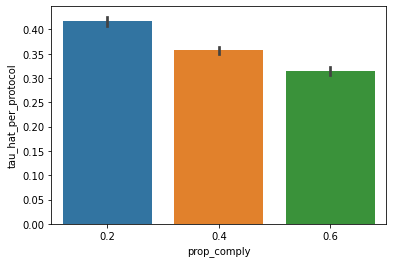

In [16]:
ax = sns.barplot(x='prop_comply', y='tau_hat_per_protocol', data=pp_strong_df)

In [17]:
taus = pp_strong_df[pp_strong_df['prop_comply'] == 0.2]['tau_hat_per_protocol']

sns.utils.ci(sns.algorithms.bootstrap(taus, n_boot=1000))

array([0.40826844, 0.42599473])

In [18]:
taus = pp_strong_df[pp_strong_df['prop_comply'] == 0.4]['tau_hat_per_protocol']

sns.utils.ci(sns.algorithms.bootstrap(taus, n_boot=1000))

array([0.34897033, 0.36483585])

In [19]:
taus = pp_strong_df[pp_strong_df['prop_comply'] == 0.6]['tau_hat_per_protocol']

sns.utils.ci(sns.algorithms.bootstrap(taus, n_boot=1000))

array([0.30669575, 0.32195679])

# Reviewer VPyL: number of individuals excluded (Table C.2)

In [22]:
result_dict = {}
for data_name in ['strong_comply', 'weak_comply', 'noise_comply']:
    # load data
    name_prefix = "../results/{}_p_comply".format(data_name) + "_{}.df"
    all_df = pd.DataFrame()
    x_var = 'Proportion compliers'

    for p_comply in prop_complys:
        gap_df = pd.read_pickle(name_prefix.format(p_comply))
        gap_df[x_var] = p_comply
        
        all_df = all_df.append(gap_df)
    
    result_dict[data_name] = all_df

In [23]:
for threshold in [0.2, 0.4, 0.6]: 
    print(f"Threshold: {threshold}")
    for data_name in ['strong_comply', 'weak_comply', 'noise_comply']:
        sel_df = result_dict[data_name][result_dict[data_name]['Proportion compliers'] == threshold]
        n_excl = n_samples - sel_df['data_driven_n_incl'].mean()
        print(f"{data_name}")
        print(f"{n_excl:.2f} average excluded, {n_excl / n_samples * 100:.2f}%")
        print()

Threshold: 0.2
strong_comply
1572.19 average excluded, 78.61%

weak_comply
1379.03 average excluded, 68.95%

noise_comply
110.30 average excluded, 5.52%

Threshold: 0.4
strong_comply
1169.43 average excluded, 58.47%

weak_comply
954.96 average excluded, 47.75%

noise_comply
35.95 average excluded, 1.80%

Threshold: 0.6
strong_comply
749.32 average excluded, 37.47%

weak_comply
559.50 average excluded, 27.97%

noise_comply
22.76 average excluded, 1.14%

